#  Lab 3  -  MULTI-CLASS CLASSIFICATION

### Step 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Description of the data

The is sourced from kaggle. 


It contains 20 different classes of birds. 
For each class we have we have about 170-180 pictures.

### Step 2. Loading the Data

In [2]:
data_dir = '/kaggle/input/birds-20-species-image-classification/train'
test_dir= '/kaggle/input/birds-20-species-image-classification/test'
val_dir = '/kaggle/input/birds-20-species-image-classification/valid'

**Let's Create A function to show us some random images with thier labels**

In [3]:
def show_random_images_with_labels(main_folder, num_images=5):
  """
  Displays a random selection of images from subfolders of the main folder,
  along with their corresponding labels (subfolder names).

  Args:
    main_folder: Path to the main folder containing subfolders of images.
    num_images: Number of images to display (default: 5).
  """

  subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
  random.shuffle(subfolders)  # Randomize the order of subfolders

  fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
  for i, subfolder in enumerate(subfolders[:num_images]):
    image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)  # Randomize the order of images within the subfolder
    image_path = image_paths[0]  # Select the first random image

    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(image_path) + f" ({os.path.basename(subfolder)})", fontsize=10)  # Add label in title

  plt.tight_layout()
  plt.show()


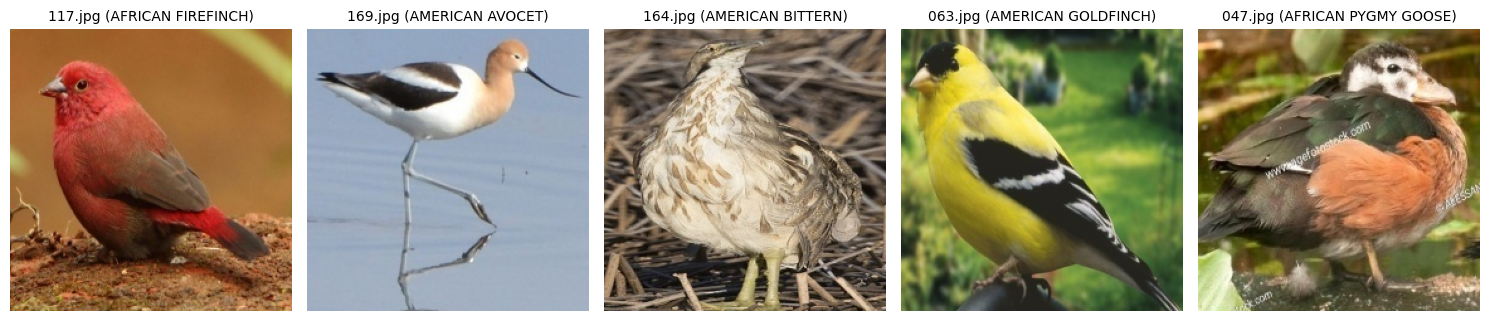

In [4]:
show_random_images_with_labels('/kaggle/input/birds-20-species-image-classification/train',5)

#### Create an ImageDataGenerator for Training / Validating and Testing data

### Some Data Preprocessing and Augmentation

 Data augmentation is a technique used to artificially increase the size and diversity of a training dataset. This helps to improve the generalization performance of a model.

 By applying these transformations to the training images, we can generate new, slightly modified versions of the original images. This helps the model learn to recognize objects and patterns in a wider range of variations, improving its robustness and accuracy.

In [5]:
data = ImageDataGenerator( zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2)


train_dg = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 32,
                                    shuffle = False,
                                    seed = 42)

Found 3208 images belonging to 20 classes.


In [6]:
data_val = ImageDataGenerator()
validation_dg = data_val.flow_from_directory(val_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 32,
                                      shuffle = False,
                                      seed = 42)

Found 100 images belonging to 20 classes.


In [7]:
testing_dg = data_val.flow_from_directory(test_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 32,
                                      shuffle = False,
                                      seed = 42)

Found 100 images belonging to 20 classes.


### Step 3 Build Architecture for the model

### TRANSFER LEARNING APPROACH

The approach involves taking a pre-trained model, leveraging the knowledege it already has and train just a few layers that was added to the  pre-trained model.


The ResNet50 is a deep CNN good for working with images. The 50 stands for the number of layers it has within it.

They're others pre-trained models like the Alexnet and others but for this lab, i prefered to  use the ResNet50.

### Brief Description of how Transfer learning works

The process is combining an already trained model, which is the pre-trained model for this case. Then add some layers with neurons to it and your final output layer.

The main difference in this architecture is that, unlike the other CNN's or DNN's  that start with initialized random weights and biases, in this case, the weights in our CNN 
block come from the knowledge it got from previous training. 

During the Training of the whole network, we freeze the CNN block so that it does not update, only the added layers are updated

#### The Almighty ResNet50 Model

In [8]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model with base features only
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
  layer.trainable = False

# Add your custom head for your specific task
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(20, activation='softmax')(x)  # in this case our birds species is 20

# Create your custom model
model = keras.Model(inputs=base_model.input, outputs=outputs)


94765736/94765736 [==============================] - 3s 0us/step


In [9]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

### Step 4. Train the model

In [10]:
history = model.fit(
      train_dg,
      epochs=5,
      validation_data = validation_dg)

Epoch 1/5
101/101 [==============================] - 98s 916ms/step - loss: 3.5099 - accuracy: 0.1587 - val_loss: 1.5958 - val_accuracy: 0.5800
Epoch 2/5
101/101 [==============================] - 66s 652ms/step - loss: 1.6738 - accuracy: 0.5125 - val_loss: 1.0181 - val_accuracy: 0.6400
Epoch 3/5
101/101 [==============================] - 65s 638ms/step - loss: 1.1477 - accuracy: 0.6652 - val_loss: 0.8080 - val_accuracy: 0.7300
Epoch 4/5
101/101 [==============================] - 74s 732ms/step - loss: 0.9638 - accuracy: 0.7051 - val_loss: 0.5568 - val_accuracy: 0.8400
Epoch 5/5
101/101 [==============================] - 67s 662ms/step - loss: 0.6594 - accuracy: 0.8186 - val_loss: 0.3638 - val_accuracy: 0.9000


### Step 5. Plotting Our Metrics 

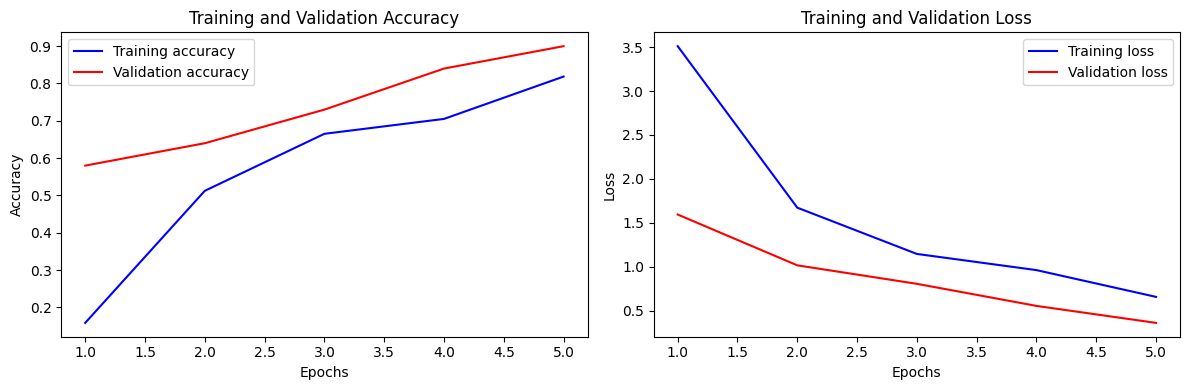

In [11]:
# Extracting training and validation metrics from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Step 6. Evaluating the model's performance on the test dataset.

In [12]:
predictions=model.evaluate(testing_dg)

4/4 [==============================] - 1s 247ms/step - loss: 0.3291 - accuracy: 0.9100


In [13]:
# Get true labels
true_labels = testing_dg.classes

# Use the model to predict the classes
predicted_labels = np.argmax(model.predict(testing_dg), axis=1)

# Display classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=testing_dg.class_indices.keys()))

4/4 [==============================] - 1s 110ms/step
Classification Report:
                             precision    recall  f1-score   support

           ABBOTTS BABBLER       0.80      0.80      0.80         5
             ABBOTTS BOOBY       1.00      0.60      0.75         5
ABYSSINIAN GROUND HORNBILL       0.71      1.00      0.83         5
     AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
    AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
         AFRICAN FIREFINCH       0.62      1.00      0.77         5
    AFRICAN OYSTER CATCHER       1.00      0.80      0.89         5
     AFRICAN PIED HORNBILL       1.00      0.80      0.89         5
       AFRICAN PYGMY GOOSE       1.00      0.60      0.75         5
                 ALBATROSS       0.83      1.00      0.91         5
            ALBERTS TOWHEE       1.00      1.00      1.00         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       0.83 

### Second Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define validation data generator (similar to train_datagen)
val_datagen = ImageDataGenerator(rescale=1./255)  # Adjust for your needs

# Use val_datagen.flow_from_directory for validation data
validation_data = val_datagen.flow_from_directory(
    '/kaggle/input/birds-20-species-image-classification/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(20, activation='softmax')  
])

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_datagen.flow_from_directory(
        '/kaggle/input/birds-20-species-image-classification/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    ),
    epochs=10,
    validation_data=validation_data
    )


###  Third Model

In [ ]:
# Assuming your input data is already flattened or reshaped to a 1D vector
model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  # Flatten the image into a 1D array
    Dense(128, activation='relu'),
    Dense(216, activation='relu'),  # Add another hidden layer for complexity
    Dense(216, activation='relu'),  # Add another hidden layer for complexity
    Dense(20, activation='softmax')  # Output layer for 20-class classification
])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_datagen.flow_from_directory(
        '/kaggle/input/birds-20-species-image-classification/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    ),
    epochs=10,
    validation_data=validation_data
    )